# What I want to do?
- first in Parallel beam
    - implement projection onto subspace of basis functions
    - test extrapolation based on finding basis coefficients
    - test extrapolation based on projection onto convex sets
- all of this generalises to arbitrary sampling (need to think about jacobian for projection - but should work) - but verify that it works for parallel beam, then I can send a note to Ozan

In [13]:
import sys
import os
from pathlib import Path
ROOT_FOLDER = Path(os.path.abspath("../../.."))
SRC = ROOT_FOLDER / "src"
if not SRC in sys.path:
    sys.path.append(SRC)

import torch
import numpy as np
import odl
import odl.contrib.torch as odl_torch
import matplotlib.pyplot as plt

from utils.geometry import ParallelGeometry, DEVICE
from models.analyticmodels import RamLak

g = ParallelGeometry(1.0, 450, 300)
ray_l = odl_torch.OperatorModule(g.ray)
bp_l = odl_torch.OperatorModule(g.BP)

kits_data = torch.load(ROOT_FOLDER / "data/kits_phantoms_256.pt")[:500, 1, :, :].to(DEVICE)
# htc_data = torch.stack(torch.load(ROOT_FOLDER / "data/HTC2022/HTCTrainingPhantoms.pt")).to(DEVICE)

kits_sinos = ray_l(kits_data)

plt.subplot(121)
plt.imshow(kits_data[0].cpu())
plt.subplot(122)
plt.imshow(kits_sinos[0].cpu())
plt.show()

67.41023135185242 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([5050, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
13.83452320098877 s to take inner products
3.141767978668213 s to sum basis functions
projection MSE tensor(0.0002)


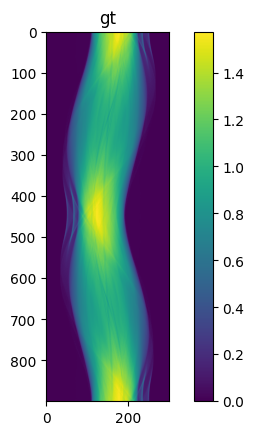

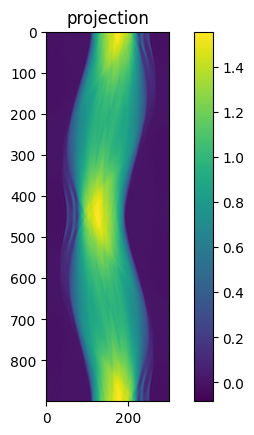

In [45]:
import numpy as np
import time
ss = torch.from_numpy(g.translations / g.rho).to(DEVICE, dtype=torch.float32)
phis = torch.concat([g.tangles, g.tangles + torch.pi]).to(DEVICE, dtype=torch.float32)

def get_Un_sink(n: int, k: int, phis: torch.Tensor, ss: torch.Tensor):    
    assert k > 0 and k <= n
    phis, ss = phis[:, None], ss[None]
    return torch.sin((n+1)*torch.acos(ss)) / torch.sqrt(1-ss**2) * torch.sin(k*phis)
def get_Un_cosk(n: int, k: int, phis: torch.Tensor, ss: torch.Tensor):
    assert k >= 0 and k <= n
    phis, ss = phis[:, None], ss[None]
    if k == 0:
        return torch.sin((n+1)*torch.acos(ss)) / torch.sqrt(1-ss**2) * (phis*0+1/np.sqrt(2.0))
    return torch.sin((n+1)*torch.acos(ss)) / torch.sqrt(1-ss**2) * torch.cos(k*phis)

def hlcc_range(N: int, skipe_zero_k):
    n = 0
    while n < N:
        k = n % 2
        while k <= n:
            if skipe_zero_k and k == 0:
                k += 2
                continue
            yield (n, k)
            k += 2
        n += 1

def project(sinos: torch.Tensor, phis: torch.Tensor, ss: torch.Tensor, udeg = 50):
    a = time.time()
    ds, dphi = torch.mean(ss[1:] -ss[:-1]), torch.mean(phis[1:] - phis[:-1])
    W = torch.sqrt(1 - ss**2)
    P = torch.stack([
        get_Un_cosk(n, k, phis, ss) for n, k in hlcc_range(udeg, skipe_zero_k=False)
    ] + [
        get_Un_sink(n, k, phis, ss) for n, k in hlcc_range(udeg, skipe_zero_k=True)
    ])
    print(time.time()-a, "s to create P")
    a = time.time()
    print("phis", phis.shape, phis.dtype)
    print("ss", ss.shape, ss.dtype)
    print("P", P.shape, P.dtype)
    print("W", W.shape, W.dtype)
    print("sinos", sinos.shape, sinos.dtype)
    proj_coeffs = torch.einsum("bps,dps->db", P*W, sinos)*ds*dphi
    print(time.time()-a, "s to take inner products")
    a = time.time()
    proj_sinos = 2/(torch.pi**2) * torch.einsum("bps,db->dps", P, proj_coeffs)
    print(time.time()-a, "s to sum basis functions")
    return proj_sinos

double_range_sinos = torch.concat([kits_sinos, torch.flip(kits_sinos, dims=(-1,))], dim=1)[:10]

proj_sinos = project(double_range_sinos, phis, ss, udeg=100)

print("projection MSE", torch.mean((proj_sinos-double_range_sinos)**2))

plt.imshow(double_range_sinos[0].cpu())
plt.title("gt")
plt.colorbar()
plt.show()
plt.imshow(proj_sinos[0].cpu())
plt.title("projection")
plt.colorbar()
plt.show()


mse between recons tensor(0.0058)
mse recon_orig tensor(0.0015)
mse recon_proj tensor(0.0094)


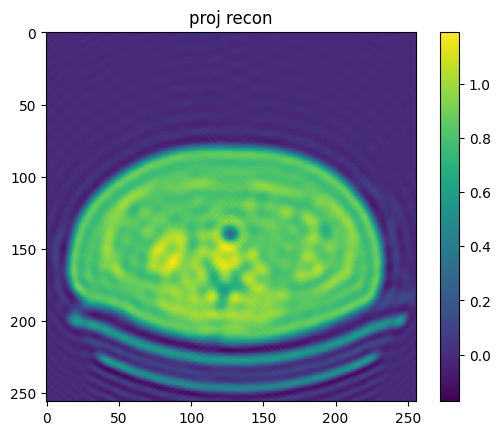

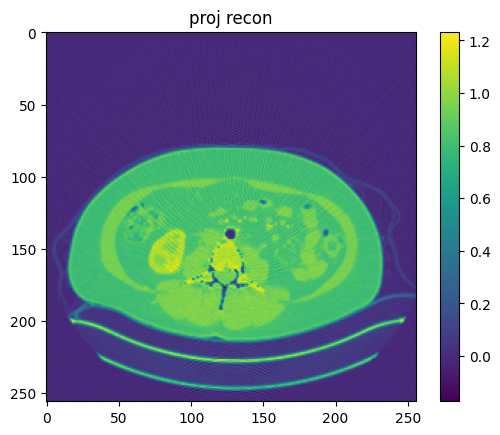

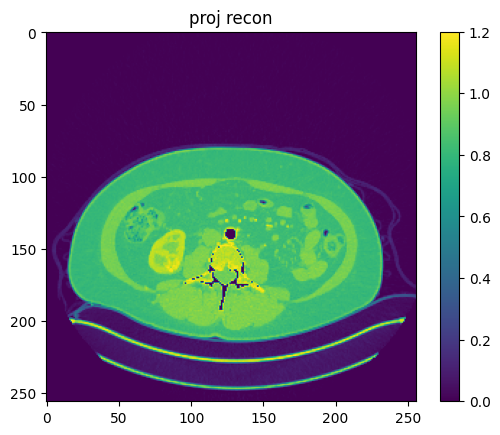

In [47]:
from models.analyticmodels import RamLak

ramlak = RamLak(g)
mse_fn = lambda diff : torch.mean(diff**2)

recons_orig = ramlak(kits_sinos[:10])
recons_proj = ramlak(proj_sinos[:, :450])

print("mse between recons", mse_fn(recons_orig-recons_proj))
print("mse recon_orig", mse_fn(recons_orig-kits_data[:10]))
print("mse recon_proj", mse_fn(recons_proj-kits_data[:10]))

plt.imshow(recons_proj[0].cpu())
plt.title("proj recon")
plt.colorbar()
plt.show()
plt.imshow(recons_orig[0].cpu())
plt.title("proj recon")
plt.colorbar()
plt.show()
plt.imshow(kits_data[0].cpu())
plt.title("proj recon")
plt.colorbar()
plt.show()

0.2951827049255371 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.14848899841308594 s to take inner products
0.17259836196899414 s to sum basis functions
iteration 1 mse: tensor(0.1835)


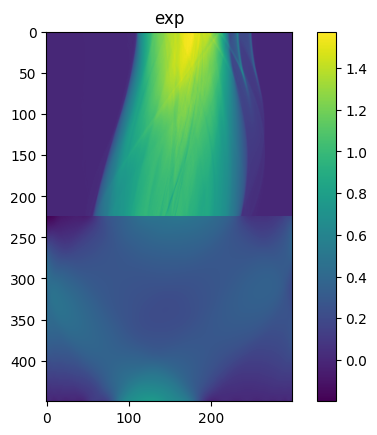

0.3360443115234375 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15102624893188477 s to take inner products
0.17711400985717773 s to sum basis functions
iteration 2 mse: tensor(0.1348)


0.3684847354888916 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16320466995239258 s to take inner products
0.18474769592285156 s to sum basis functions
iteration 3 mse: tensor(0.1196)


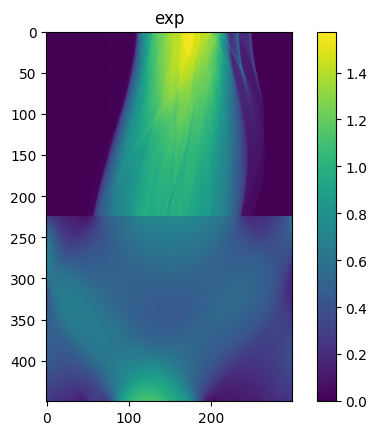

0.6664154529571533 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.20354938507080078 s to take inner products
0.20670127868652344 s to sum basis functions
iteration 4 mse: tensor(0.1107)


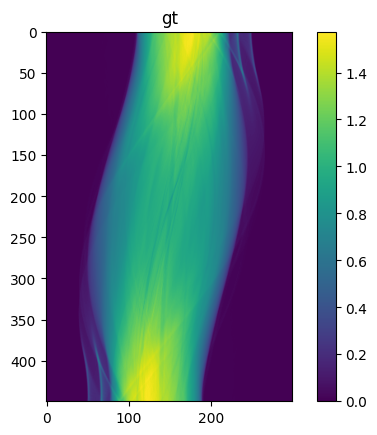

0.3444216251373291 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16364192962646484 s to take inner products
0.1781017780303955 s to sum basis functions
iteration 5 mse: tensor(0.1030)


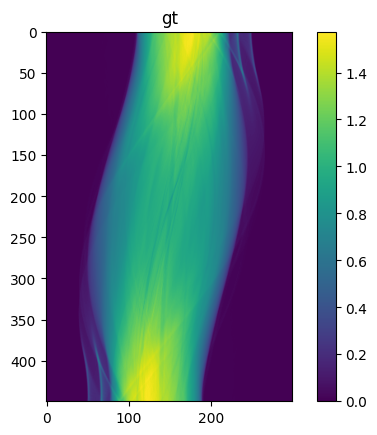

0.34029245376586914 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15684103965759277 s to take inner products
0.18895268440246582 s to sum basis functions
iteration 6 mse: tensor(0.0956)


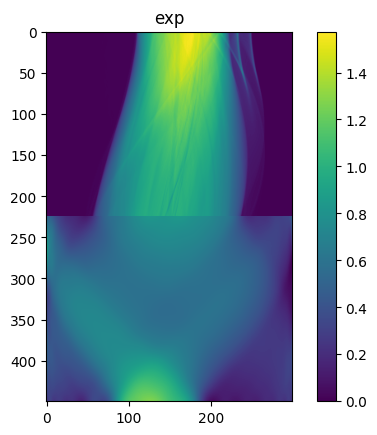

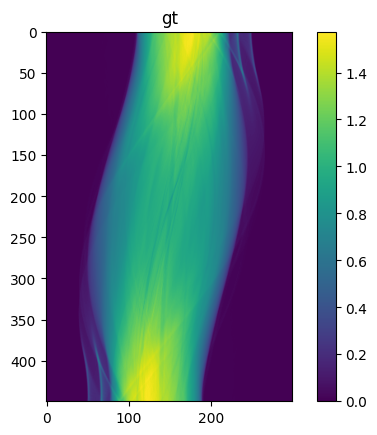

0.3180229663848877 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15728425979614258 s to take inner products
0.15630245208740234 s to sum basis functions
iteration 7 mse: tensor(0.0887)


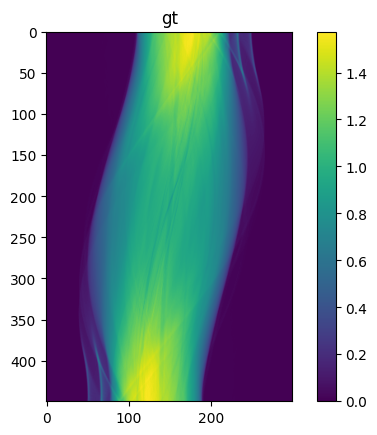

0.3356435298919678 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15910863876342773 s to take inner products
0.2145242691040039 s to sum basis functions
iteration 8 mse: tensor(0.0824)


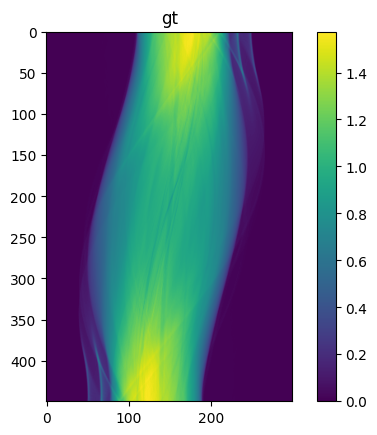

0.3230304718017578 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.1616978645324707 s to take inner products
0.17465615272521973 s to sum basis functions
iteration 9 mse: tensor(0.0767)


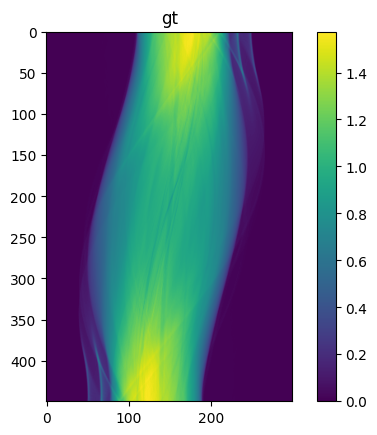

0.3808133602142334 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.1638929843902588 s to take inner products
0.1796882152557373 s to sum basis functions
iteration 10 mse: tensor(0.0716)


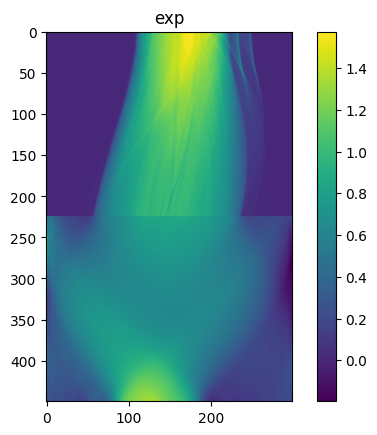

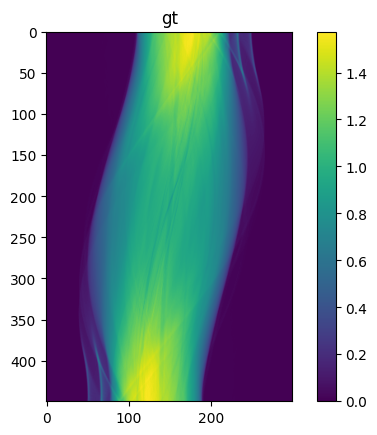

0.3880472183227539 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.1609334945678711 s to take inner products
0.18048381805419922 s to sum basis functions
iteration 11 mse: tensor(0.0670)


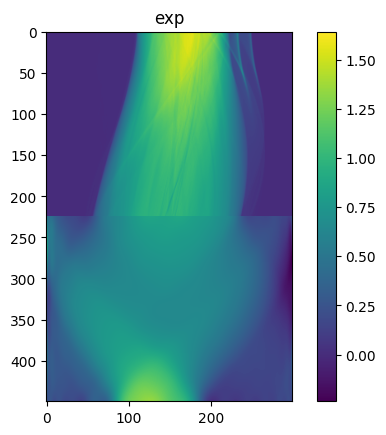

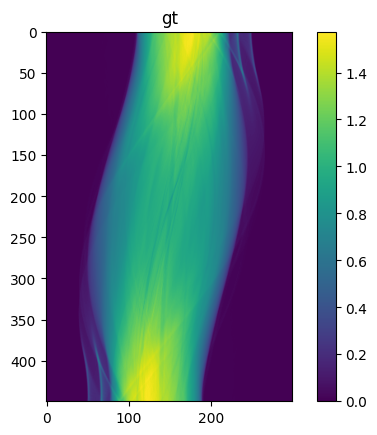

0.4607729911804199 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.2172253131866455 s to take inner products
0.24108147621154785 s to sum basis functions
iteration 12 mse: tensor(0.0630)


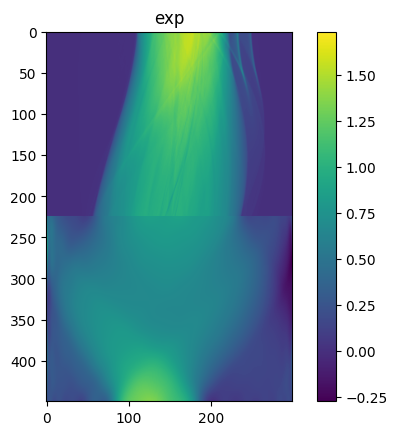

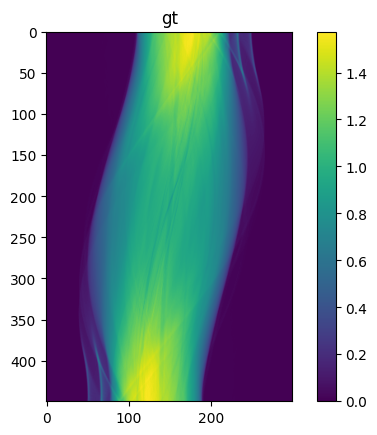

0.3265082836151123 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16709136962890625 s to take inner products
0.19460725784301758 s to sum basis functions
iteration 13 mse: tensor(0.0594)


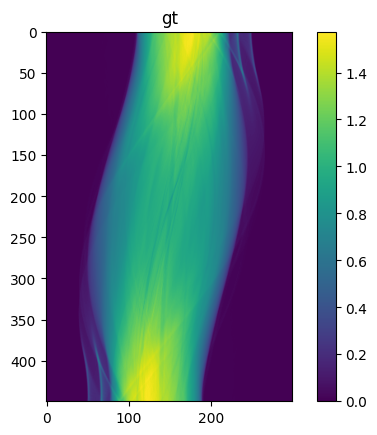

0.37369632720947266 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.1681969165802002 s to take inner products
0.1858506202697754 s to sum basis functions
iteration 14 mse: tensor(0.0564)


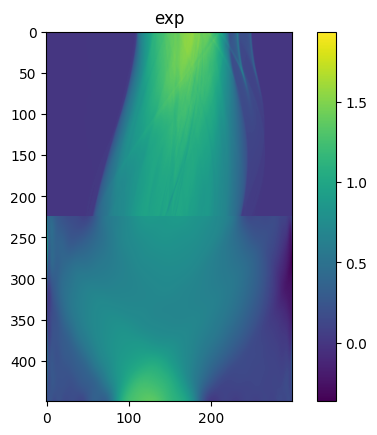

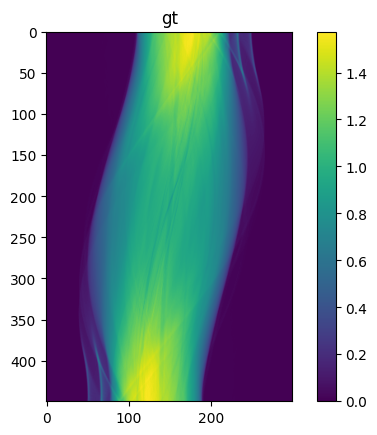

0.3744809627532959 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.1571657657623291 s to take inner products
0.1793506145477295 s to sum basis functions
iteration 15 mse: tensor(0.0537)


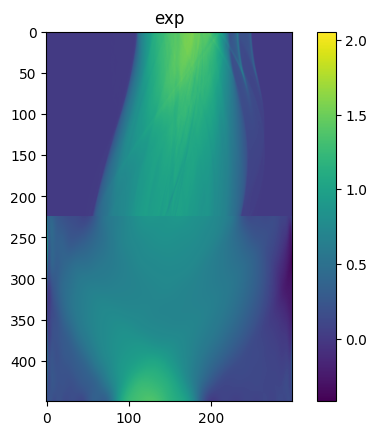

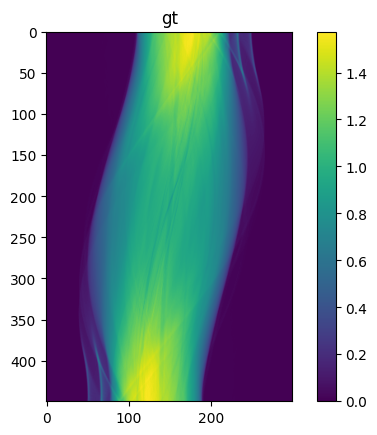

0.3474743366241455 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15254998207092285 s to take inner products
0.19605350494384766 s to sum basis functions
iteration 16 mse: tensor(0.0515)


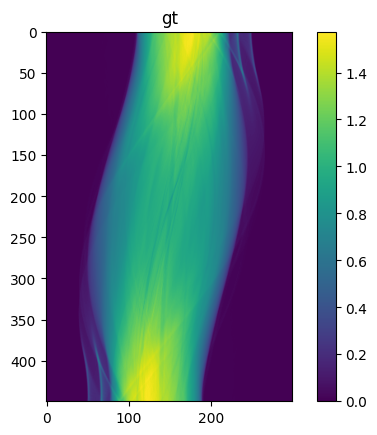

0.32813119888305664 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.14811325073242188 s to take inner products
0.15558290481567383 s to sum basis functions
iteration 17 mse: tensor(0.0496)


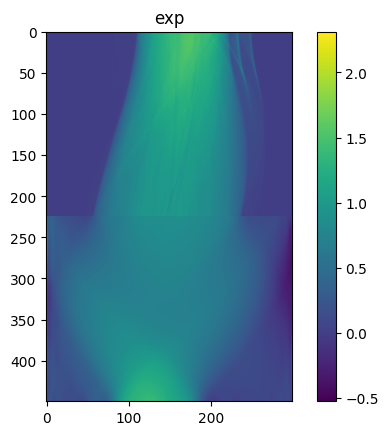

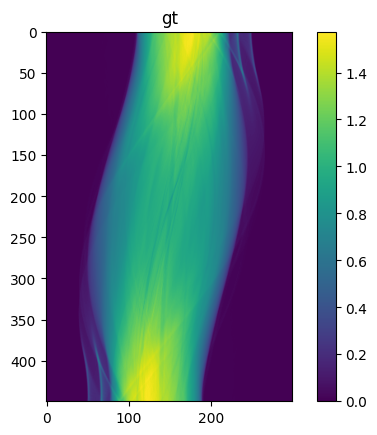

0.35843729972839355 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16156792640686035 s to take inner products
0.18022942543029785 s to sum basis functions
iteration 18 mse: tensor(0.0481)


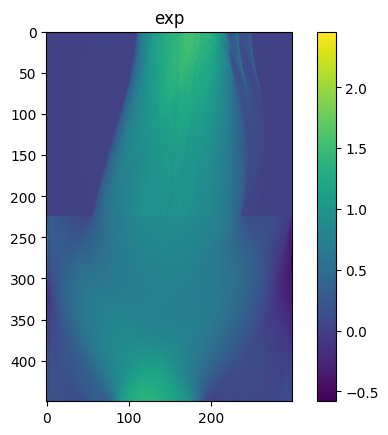

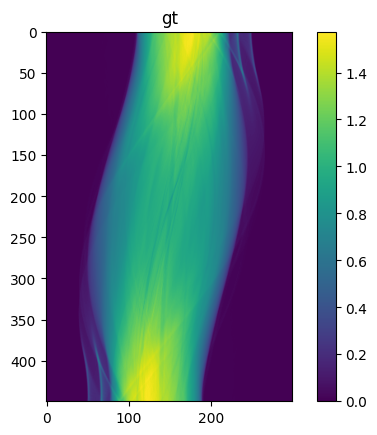

0.3521401882171631 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15712547302246094 s to take inner products
0.2032618522644043 s to sum basis functions
iteration 19 mse: tensor(0.0470)


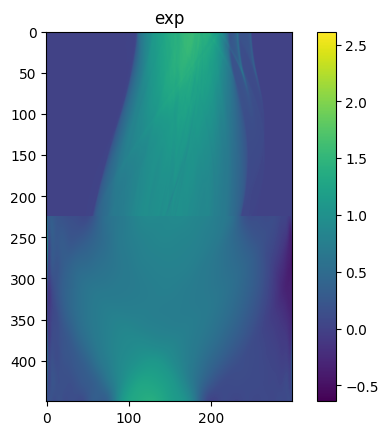

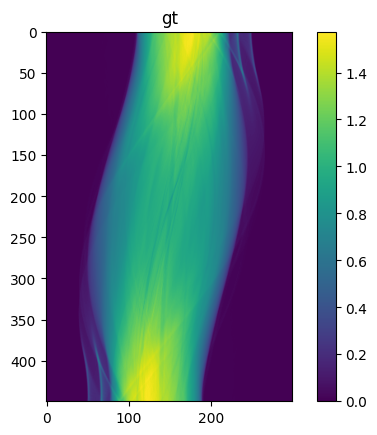

0.3210113048553467 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16506671905517578 s to take inner products
0.23325133323669434 s to sum basis functions
iteration 20 mse: tensor(0.0463)


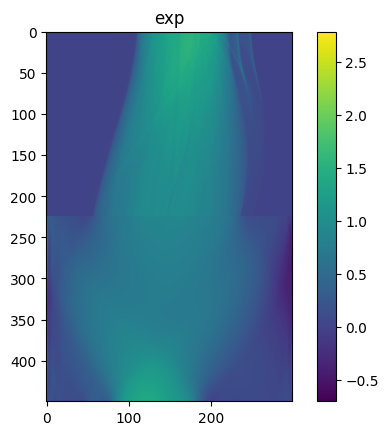

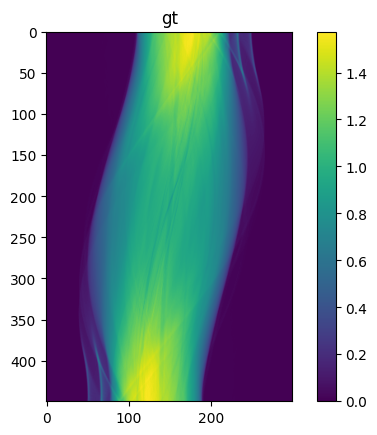

0.34532809257507324 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.14377188682556152 s to take inner products
0.15035533905029297 s to sum basis functions
iteration 21 mse: tensor(0.0459)


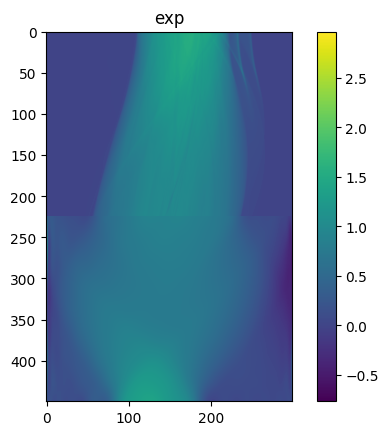

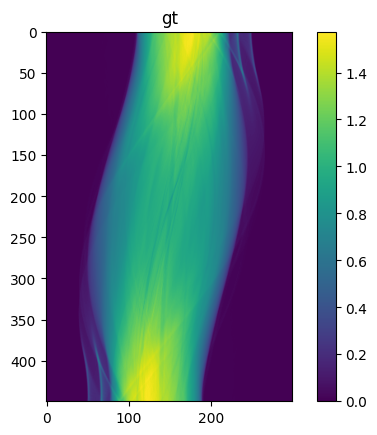

0.3655714988708496 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16238737106323242 s to take inner products
0.1851506233215332 s to sum basis functions
iteration 22 mse: tensor(0.0459)


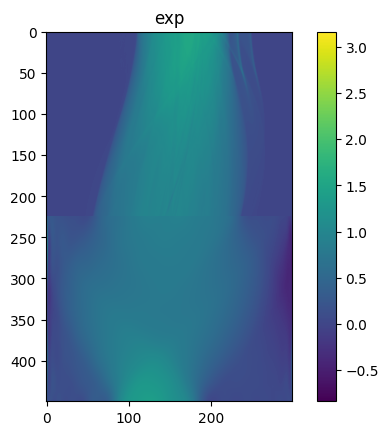

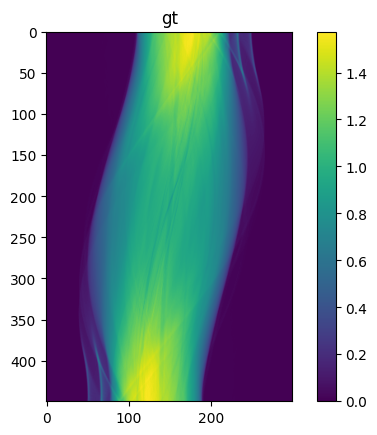

0.33677148818969727 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.18537354469299316 s to take inner products
0.18346905708312988 s to sum basis functions
iteration 23 mse: tensor(0.0463)


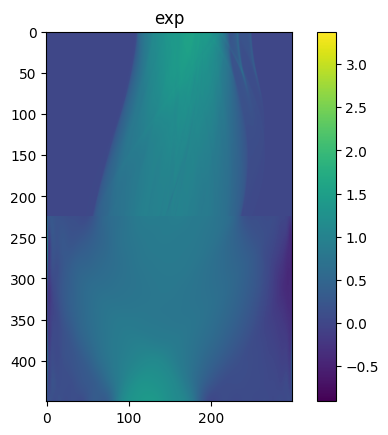

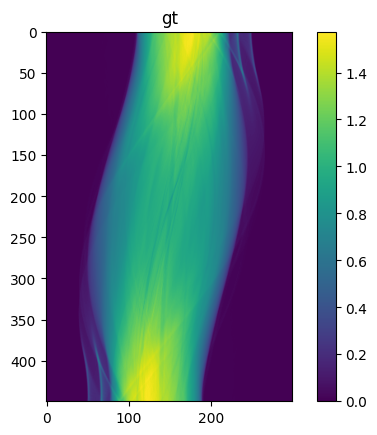

0.3604562282562256 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.17053484916687012 s to take inner products
0.17773652076721191 s to sum basis functions
iteration 24 mse: tensor(0.0471)


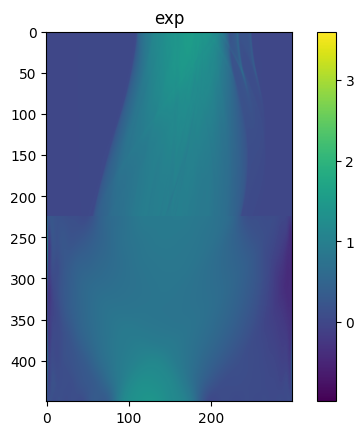

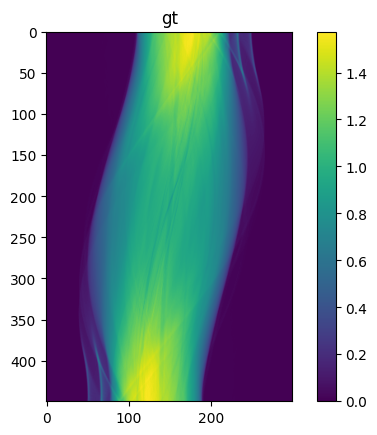

0.3783736228942871 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16599225997924805 s to take inner products
0.17839717864990234 s to sum basis functions
iteration 25 mse: tensor(0.0484)


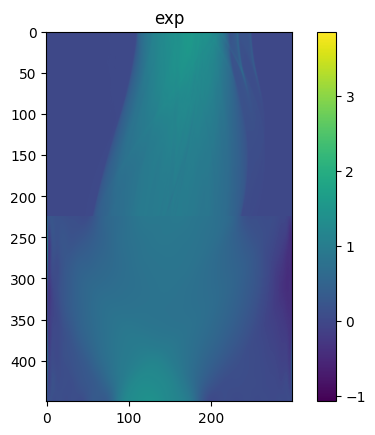

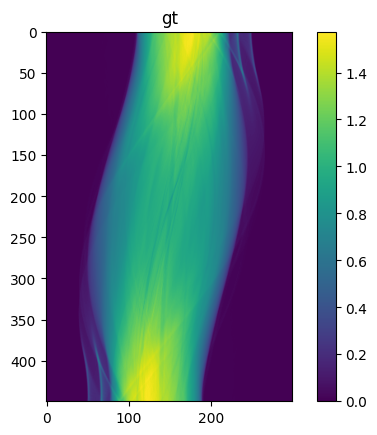

0.3818659782409668 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16840147972106934 s to take inner products
0.1677711009979248 s to sum basis functions
iteration 26 mse: tensor(0.0502)


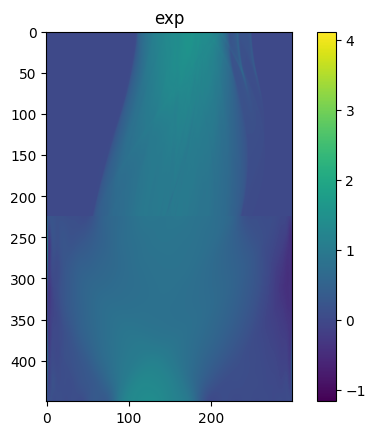

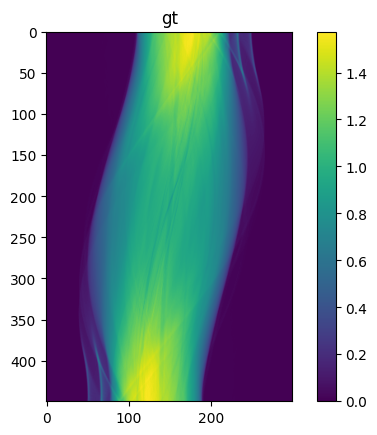

0.4007091522216797 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.166029691696167 s to take inner products
0.16472077369689941 s to sum basis functions
iteration 27 mse: tensor(0.0525)


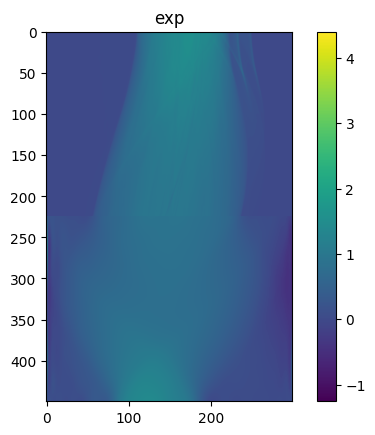

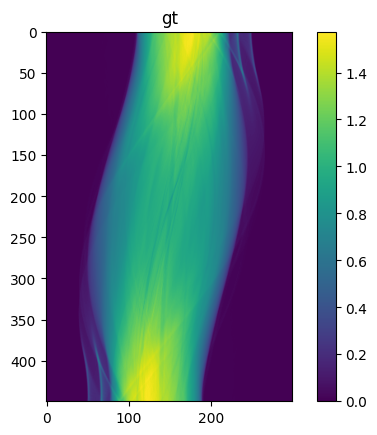

0.3579738140106201 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.17760324478149414 s to take inner products
0.2346036434173584 s to sum basis functions
iteration 28 mse: tensor(0.0555)


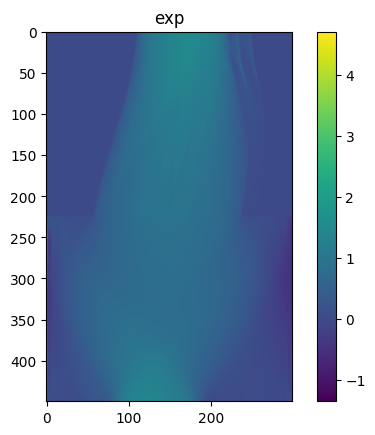

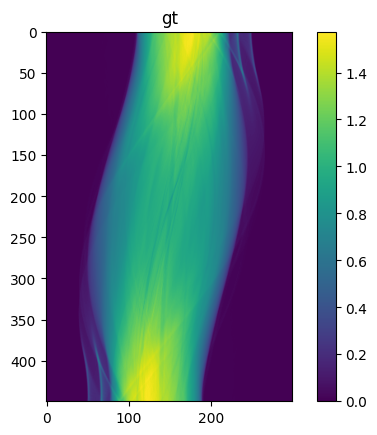

0.3859138488769531 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.16106963157653809 s to take inner products
0.1596660614013672 s to sum basis functions
iteration 29 mse: tensor(0.0591)


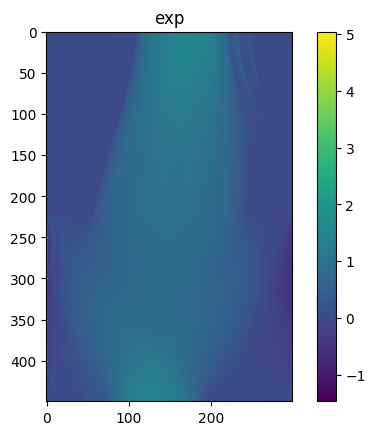

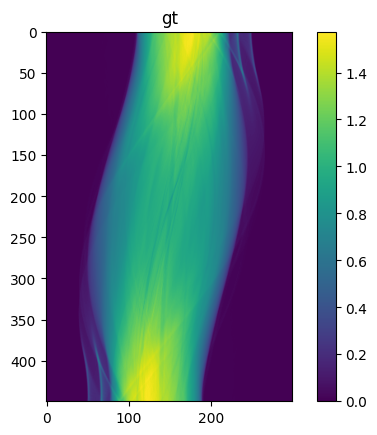

0.3416736125946045 s to create P
phis torch.Size([900]) torch.float32
ss torch.Size([300]) torch.float32
P torch.Size([465, 900, 300]) torch.float32
W torch.Size([300]) torch.float32
sinos torch.Size([10, 900, 300]) torch.float32
0.15433621406555176 s to take inner products
0.18082261085510254 s to sum basis functions
iteration 30 mse: tensor(0.0636)


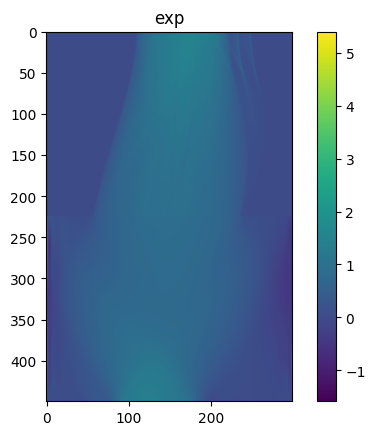

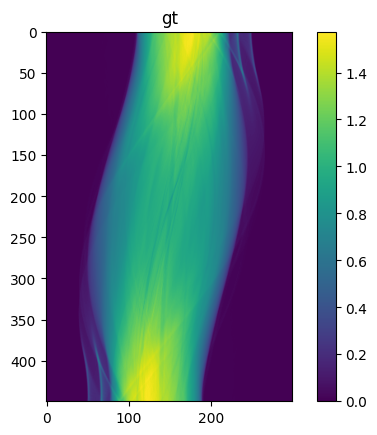

In [55]:
#Attempt for iterative analytic sinogram extrapolation based o HLCC

half_sinos = kits_sinos[:10] * 1
half_sinos[:, 225:, :] = 0

exp_sinos = half_sinos*1
for it in range(30):
    proj_sinos = project(torch.concat([exp_sinos, torch.flip(exp_sinos, dims=(-1,))], dim=1), phis, ss, 20)
    exp_sinos[:, 225:, :] = proj_sinos[:, 225:450, :]

    print("="*40)
    print("iteration", it+1, "mse:", mse_fn(exp_sinos-kits_sinos[:10]))
    plt.imshow(exp_sinos[0].cpu())
    plt.title("exp")
    plt.colorbar()
    plt.show()
    plt.imshow(kits_sinos[0].cpu())
    plt.title("gt")
    plt.colorbar()
    plt.show()
    print("="*40)